**Проект: Прогнозирование температуры плавления стали**

**Описание проекта:**
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.
Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Цель проекта:** Построить модель, которая предскажет температуру стали.

**План работы:**
1. Провести загрузку и предобработку данных
2. Провести EDA и подготовку данных для построения модели
2. Построить модель, которая предскажет температуру стали
3. Проверить эффективность лучшей модели на тестовой выборке
4. Вывод
5. Отчет о проделанной работе

Вопросов по проекту пока нет.

### Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.dummy import DummyRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")


RANDOM_STATE = 170723

Загрузим данные

In [2]:
df_arc=pd.read_csv('/datasets/data_arc_new.csv')
df_bulk=pd.read_csv('/datasets/data_bulk_new.csv')
df_gas=pd.read_csv('/datasets/data_gas_new.csv')
df_temp=pd.read_csv('/datasets/data_temp_new.csv')
df_wire=pd.read_csv('/datasets/data_wire_new.csv')
df_bulk_time=pd.read_csv('/datasets/data_bulk_time_new.csv')
df_wire_time=pd.read_csv('/datasets/data_wire_time_new.csv')

Напишем функцию для предварительной оценки данных

In [3]:
def data_eval(df):
    print('Общая информация о датасете')
    display(df.info())
    print('---------------------------')
    print('Вывод первых строк датасета')
    display(df.head())
    print('---------------------------')
    print('Cтатистическиe данные')
    display(df.describe())
    print('---------------------------')
    print('Количество дубликатов')
    display(df.duplicated().sum())
    print('---------------------------')
    print('Пропущенные значения')
    display(df.isna().sum())
    print('---------------------------')
    print('Уникальные значения номера партии')
    display(len(df['key'].unique()))

Смотрим данные об электродах

In [4]:
print(data_eval(df_arc))

Общая информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

---------------------------
Вывод первых строк датасета


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


---------------------------
Cтатистическиe данные


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


---------------------------
Количество дубликатов


0

---------------------------
Пропущенные значения


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

---------------------------
Уникальные значения номера партии


3214

None


Визуализируем распределение данных мощности

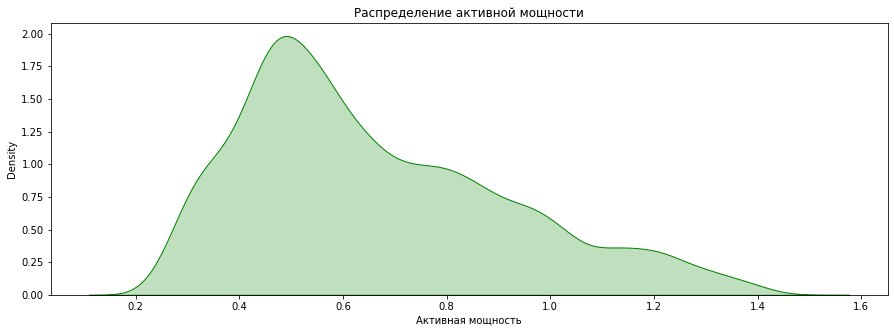

In [5]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Активная мощность'],color='g', legend=True,shade=True)
plt.title('Распределение активной мощности')
plt.show()

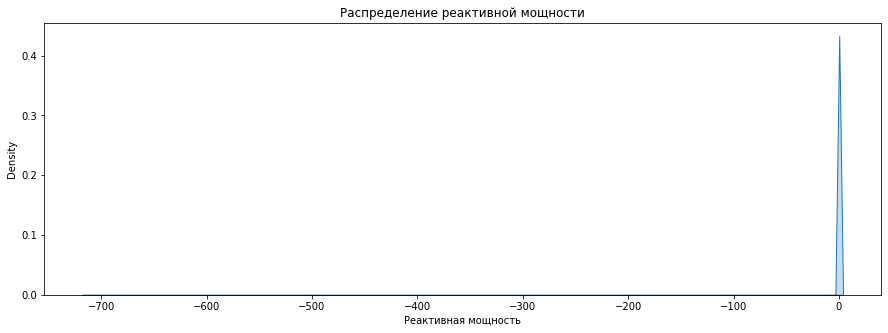

In [6]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Реактивная мощность'], legend=True,shade=True)
plt.title('Распределение реактивной мощности')
plt.show()

Распределения близки к нормальному, у обоих присутствует правая ассиметрия

В данных об электродах пропусков и дубликатов нет. Вопросы вызывает отрицательная реактивная мощность в статистике (это выброс скорее всего) и тип данных.

Приведем данные к нужному типу

In [7]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], \
                                                format='%Y-%m-%dT%H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], \
                                               format='%Y-%m-%dT%H:%M:%S')

In [8]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Удалим аномалии в данных

In [9]:
df_arc =df_arc[df_arc['Реактивная мощность'] >= 0]

Смотрим данные о подаче сыпучих материалов (объём)

In [10]:
data_eval(df_bulk)

Общая информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

---------------------------
Вывод первых строк датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


---------------------------
Cтатистическиe данные


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


---------------------------
Количество дубликатов


0

---------------------------
Пропущенные значения


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

---------------------------
Уникальные значения номера партии


3129

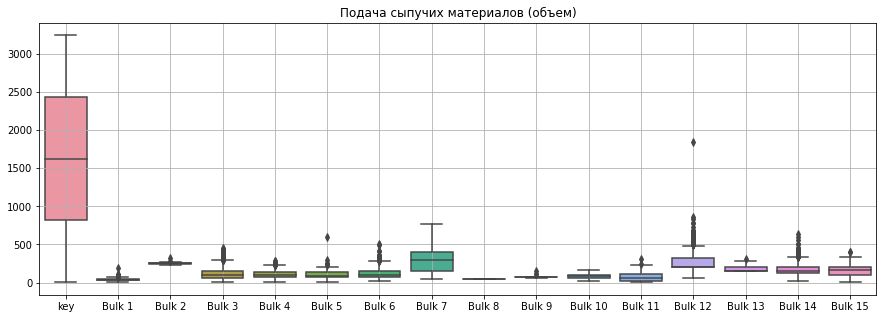

In [11]:
plt.figure(figsize=(15,5))
plt.title('Подача сыпучих материалов (объем)')
sns.boxplot(data=df_bulk)
plt.grid();

Наблюдаем единичные выбросы bulk_5 и bulk_12, пока оставим как есть

Типы данных в порядке, дубликатов нет. Есть пропуски значений. Оставим без изменений.

Смотрим данные о подаче сыпучих материалов (время)

In [12]:
data_eval(df_bulk_time)

Общая информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

---------------------------
Вывод первых строк датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


---------------------------
Cтатистическиe данные


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


---------------------------
Количество дубликатов


0

---------------------------
Пропущенные значения


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

---------------------------
Уникальные значения номера партии


3129

Дубликатов нет. Есть пропуски в данных. Похоже, что пропуски совпадают с пропусками датасета  df_bulk. Проверим.

In [13]:
print((df_bulk_time.isna() == df_bulk.isna()).sum()) 

key        3129
Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64


Совпадают. Предположу, что это отсутствие засыпки на определенном этапе.

Посмотрим на данные о продувке сплава газом

In [14]:
data_eval(df_gas)

Общая информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

---------------------------
Вывод первых строк датасета


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


---------------------------
Cтатистическиe данные


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


---------------------------
Количество дубликатов


0

---------------------------
Пропущенные значения


key      0
Газ 1    0
dtype: int64

---------------------------
Уникальные значения номера партии


3239

Дубликатов и пропусков в данных нет. Тип данных в порядке. 

Посмотрим на распределение данных. Близко к нормальному.

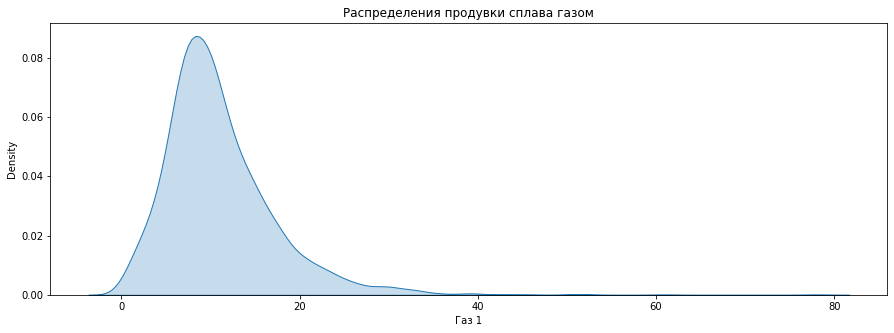

In [15]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_gas['Газ 1'], legend=True,shade=True)
plt.title('Распределения продувки сплава газом')
plt.show()

Смотрим на результаты измерения температуры

In [16]:
data_eval(df_temp)

Общая информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

---------------------------
Вывод первых строк датасета


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


---------------------------
Cтатистическиe данные


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


---------------------------
Количество дубликатов


0

---------------------------
Пропущенные значения


key                0
Время замера       0
Температура     3427
dtype: int64

---------------------------
Уникальные значения номера партии


3216

Оценим распределение данных  - есть выбросы ниже 1500 градусов, по ТЗ их надо будет удалить

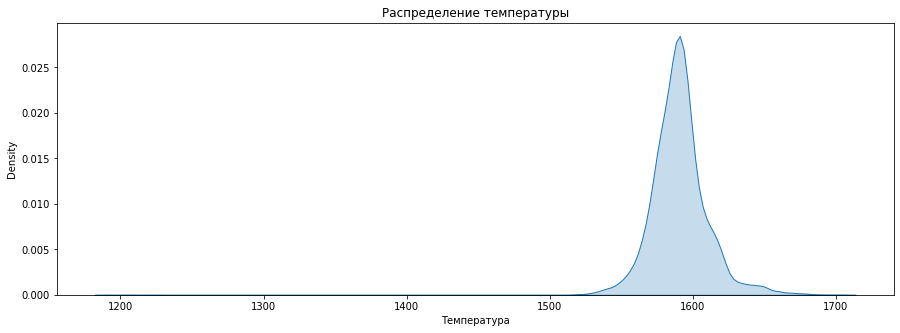

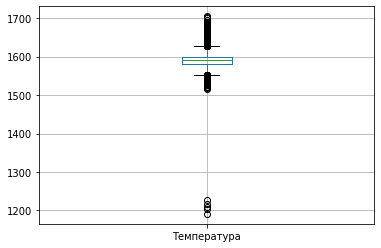

In [17]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_temp['Температура'], legend=True,shade=True)
plt.title('Распределение температуры')
plt.show()
fig2 =df_temp.boxplot('Температура')


Дубликатов в данных нет. Пропуски в признаке температура - видимо надо удалить, заменить не на что. Тип данных времени замера приведем в порядок.

In [18]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

In [19]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Удалим пропуски в данных

In [20]:
df_temp.dropna().reset_index(drop = True)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
14660,3237,2019-09-06 11:31:15,1569.0
14661,3238,2019-09-06 12:16:15,1584.0
14662,3239,2019-09-06 14:16:50,1598.0
14663,3240,2019-09-06 15:25:21,1617.0


Смотрим на данные о проволочных материалах (объём)

In [21]:
data_eval(df_wire)

Общая информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

---------------------------
Вывод первых строк датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------
Cтатистическиe данные


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


---------------------------
Количество дубликатов


0

---------------------------
Пропущенные значения


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

---------------------------
Уникальные значения номера партии


3081

Дубликатов в данных нет. Имеются пропуски. Тип данных в порядке.

Смотрим на данные о проволочных материалах (время)

In [22]:
data_eval(df_wire_time)

Общая информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

---------------------------
Вывод первых строк датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------
Cтатистическиe данные


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


---------------------------
Количество дубликатов


0

---------------------------
Пропущенные значения


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

---------------------------
Уникальные значения номера партии


3081

Дубликатов в данных нет. Имеются пропуски и надо сравнить их количество с датасетом df_wire.

In [23]:
print((df_wire.isna() == df_wire_time.isna()).sum())

key       3081
Wire 1    3081
Wire 2    3081
Wire 3    3081
Wire 4    3081
Wire 5    3081
Wire 6    3081
Wire 7    3081
Wire 8    3081
Wire 9    3081
dtype: int64


Пропуски совпадают. Как и в случае с сыпучими материалами, предполагаю, что пропуски - не подача проволоки

Правильно было бы для единообразия все названия признаков привести к нужному стилю, языку, регистру

In [24]:
df_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
df_bulk.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']
df_bulk_time.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']
df_gas.columns = ['key', 'gas_1']
df_temp.columns = ['key', 'time','temp']
df_wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
df_wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

Проверим

In [25]:
df_arc.head()

,key,start_time,end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Вывод. Предоставленные данные загружены и проведена предварительная оценка их качества. Дубликатов в данных нет, имеются пропуски, часть которых мы удалили не имея возможности замены, а часть оставили без изменений, предварительно полагая, что это технологически обосновано. Возможно, в дальнейшем пропущенные значения заполним.  Тип данных, где это необходимо приведен в порядок. Одинаковый регистр, язык, стиль также применен ко всем датасетам. Очевидно, что данные требуют групировки по номеру партии key. Количество уникальных key в таблицах разное, поэтому при объединении таблиц по key часть данных будет отсутствовать. Нашим целевым признаком будет последний замер температуры в df_temp.

### Подготовка данных для построения модели

Определим количество итераций нагрева

In [26]:
df_arc_count = df_arc.groupby(by = 'key', as_index = False).count()[['key','start_time']]
df_arc_count.columns = ['key','Количество итераций нагрева']

In [27]:
df_arc_count

,key,Количество итераций нагрева
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


Сгруппируем по партиям

In [28]:
df_arc = df_arc.groupby(by = 'key', as_index = False).sum()
df_arc = df_arc.merge(df_arc_count, how='left', on = 'key')

In [29]:
df_arc

,key,active_power,reactive_power,Количество итераций нагрева
0,1,3.036730,2.142821,5
1,2,2.139408,1.453357,4
2,3,4.063641,2.937457,5
3,4,2.706489,2.056992,4
4,5,2.252950,1.687991,4
...,...,...,...,...
3209,3237,2.541872,2.025417,5
3210,3238,1.374821,1.038103,3
3211,3239,4.848005,3.541541,8
3212,3240,3.317679,2.373552,5


Удалим пропущенные значения в данных по замерам температуры, а также где имеется только один замер

In [30]:
df_temp = df_temp.dropna(subset=['temp']).reset_index(drop=True)
df_temp = df_temp.sort_values(by=['time'])

count = df_temp.groupby(by = 'key', as_index=False).count()
one = count[count['time']== 1]['key'].tolist()
df_temp = df_temp.query('key not in @one')

In [31]:
df_temp

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


Удалим строки со значениями менее 1500 градусов (по условию)

In [32]:
df_temp =df_temp[df_temp['temp'] >= 1500]

In [33]:
df_temp.describe()

,key,temp
count,13920.000000,13920.000000
mean,1243.619181,1590.911494
std,719.133465,18.774355
min,1.000000,1515.000000
25%,624.000000,1580.000000
50%,1246.000000,1590.000000
75%,1870.000000,1599.000000
max,2499.000000,1705.000000


Cгруппируем данные по первым и последним значениям замеров температуры

In [34]:
df_temp = df_temp.groupby(by ='key').agg(['first', 'last']).reset_index()
df_temp.columns = df_temp.columns.droplevel()
df_temp.columns = ['key', 'time_1', 'time_2','temp_1',\
                   'temp_2']
df_temp = df_temp[['key','temp_1','temp_2']]

In [35]:
df_temp

,key,temp_1,temp_2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


Прежде чем формировать общую сводную таблицу данных, обратим внимание на активную и реактивную мощность, описанные в 1 пункте. Проверим корреляцию этих признаков

In [36]:
print('Корреляция', df_arc['active_power'].corr(df_arc['reactive_power']))

Корреляция 0.9925176234568434


Корреляции почти полная. Возможно переобучение модели, заменим одним признаком - полной мощностью. Рассчитаем ее.

In [37]:
def full_power(row):
        
    full_power= math.sqrt(row['active_power']**2 + row['reactive_power']**2)
    return full_power

In [38]:
df_arc['full_power'] = df_arc.apply(full_power, axis=1)

In [39]:
df_arc = df_arc.drop(['active_power', 'reactive_power'], axis=1)


In [40]:
df_arc

,key,Количество итераций нагрева,full_power
0,1,5,3.716640
1,2,4,2.586371
2,3,5,5.014163
3,4,4,3.399456
4,5,4,2.815155
...,...,...,...
3209,3237,5,3.250143
3210,3238,3,1.722728
3211,3239,8,6.003804
3212,3240,5,4.079307


Посмотрим на распределение полной мощности

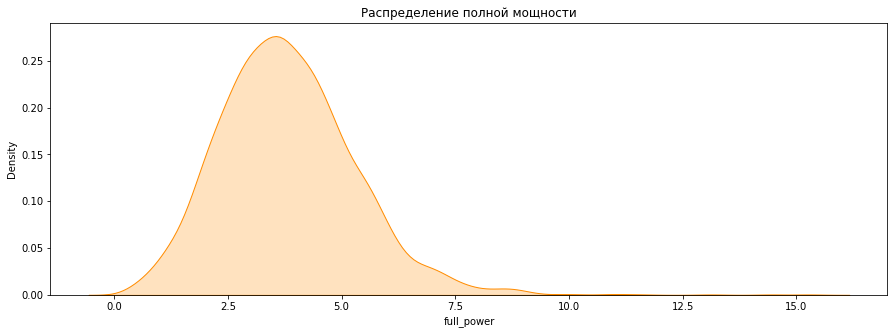

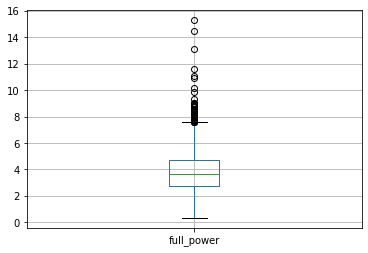

In [41]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['full_power'], color='darkorange',legend=True,shade=True)
plt.title('Распределение полной мощности')
plt.show()
fig2 =df_arc.boxplot('full_power')

Распределение данных выглядит лучше, чем распределения активной и реактивной мощностей. Есть единичные выбросы, вполне возможно есть технологическое обоснование пренебречь ими.

Объединим по inner, удалим строки где нет ни одной присадки или нет газа

In [42]:
data = (df_temp.merge(df_arc, how='inner', on = 'key').merge(df_wire, how='inner', on = 'key').merge(df_bulk, how='inner', on = 'key').merge(df_gas, how='inner', on = 'key'))

In [43]:
data

,key,temp_1,temp_2,Количество итераций нагрева,full_power,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
0,1,1571.0,1613.0,5,3.716640,60.059998,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.749986
1,2,1581.0,1602.0,4,2.586371,96.052315,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561
2,3,1596.0,1599.0,5,5.014163,91.160157,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793
3,4,1601.0,1625.0,4,3.399456,89.063515,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219
4,5,1576.0,1602.0,4,2.815155,89.238236,9.11456,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,4,3.863328,89.150879,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,90.0,NaN,256.0,NaN,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,6,5.067396,114.179527,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,3,4.360104,94.086723,9.04800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,230.0,NaN,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,5,3.907887,118.110717,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,101.0,NaN,206.0,NaN,129.0,207.0,14.953657


Заменим пропущенные значения в признаках на нули

In [44]:
data = data.fillna(0)

In [45]:
data

,key,temp_1,temp_2,Количество итераций нагрева,full_power,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
0,1,1571.0,1613.0,5,3.716640,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,4,2.586371,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,5,5.014163,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,4,3.399456,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,4,2.815155,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,4,3.863328,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,6,5.067396,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,3,4.360104,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,5,3.907887,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


In [46]:
data.rename(columns={'Количество итераций нагрева': 'count_iter'}, inplace= True )

In [47]:
data

,key,temp_1,temp_2,count_iter,full_power,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
0,1,1571.0,1613.0,5,3.716640,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,4,2.586371,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,5,5.014163,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,4,3.399456,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,4,2.815155,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,4,3.863328,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,6,5.067396,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,3,4.360104,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,5,3.907887,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


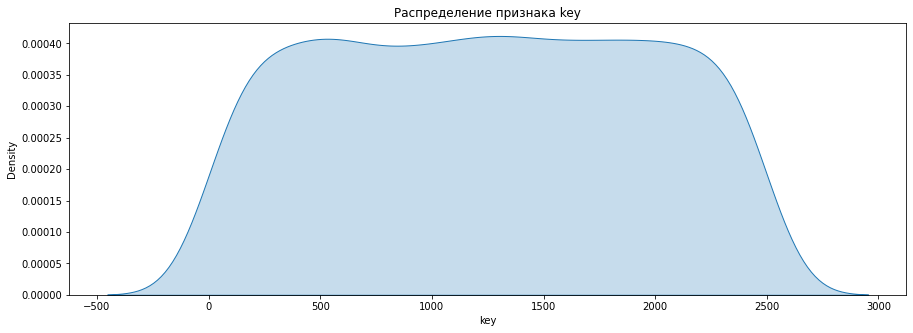

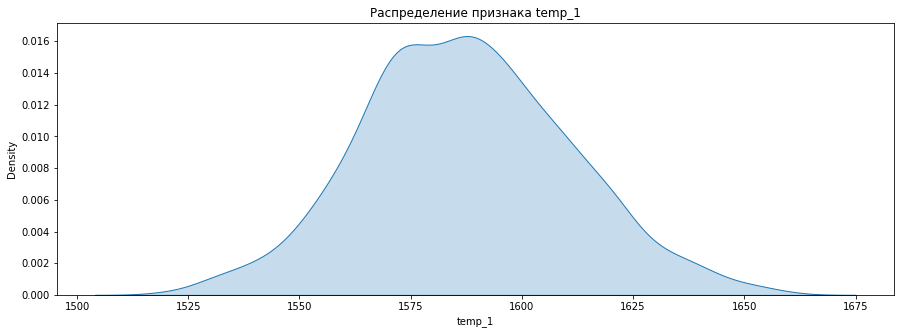

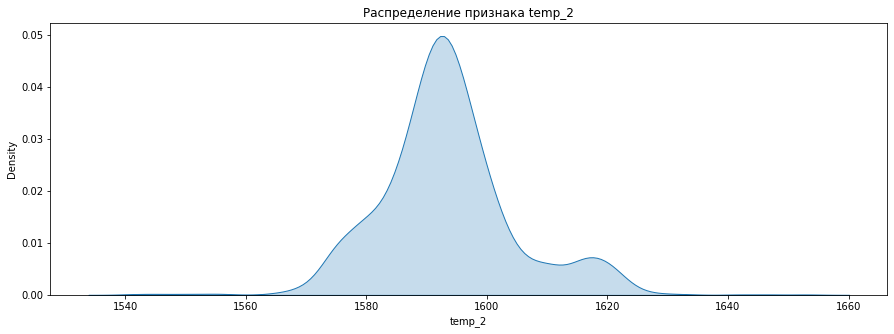

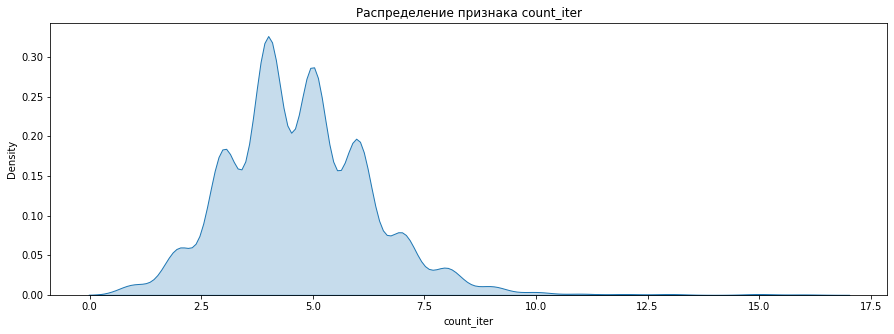

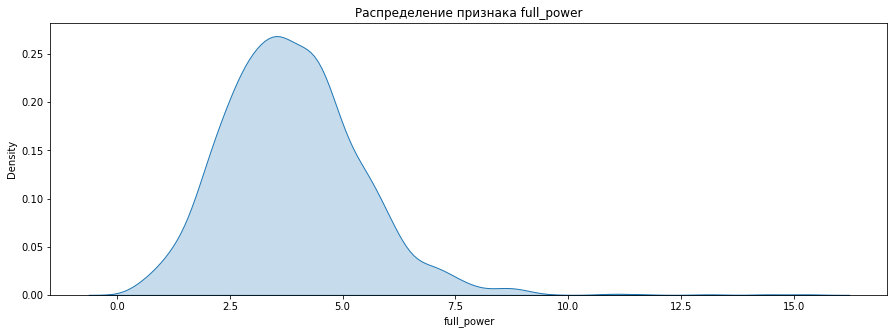

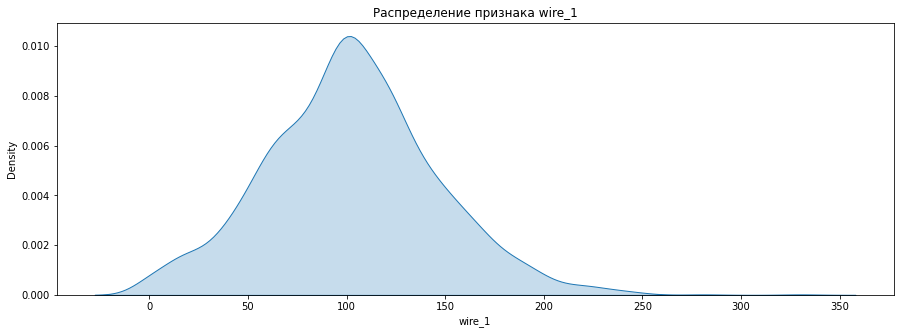

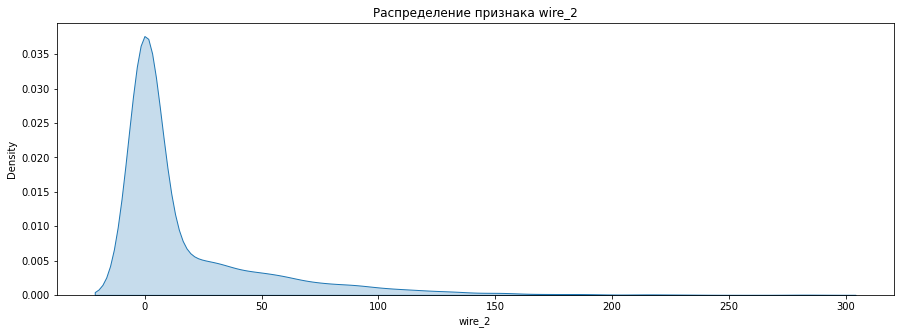

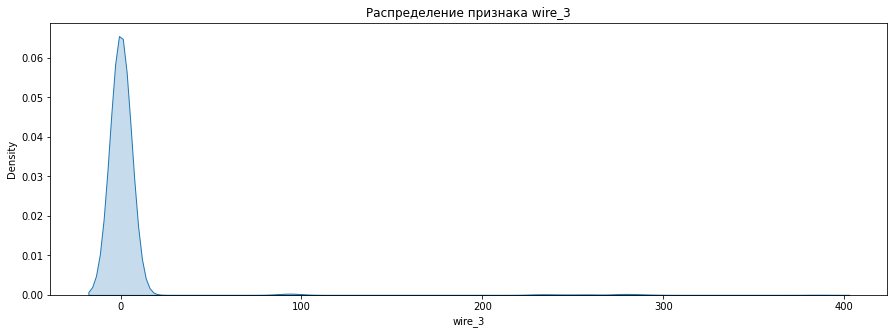

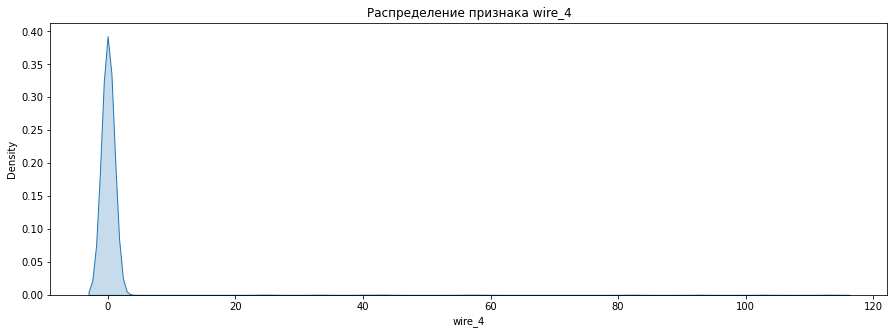

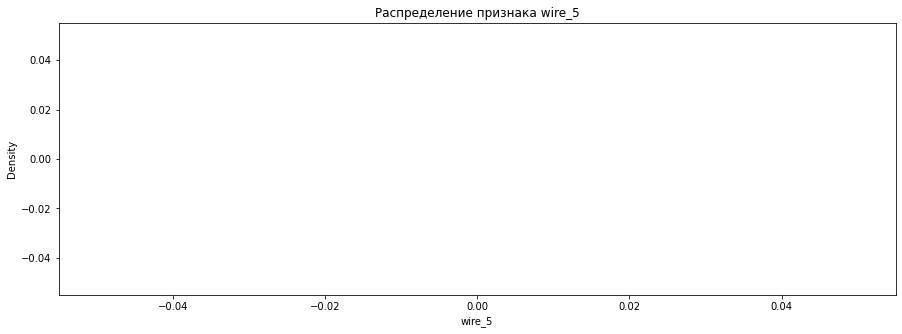

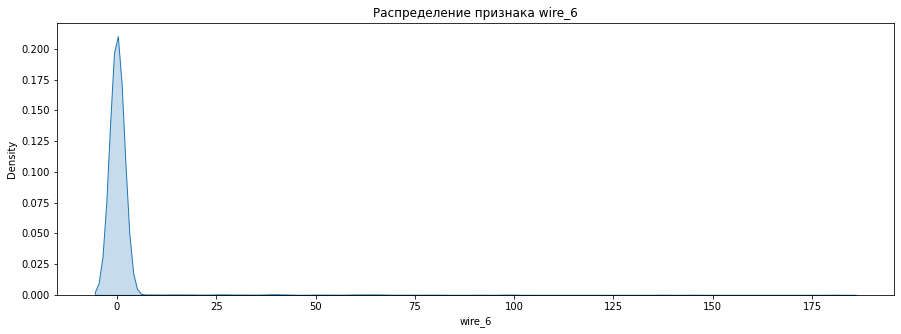

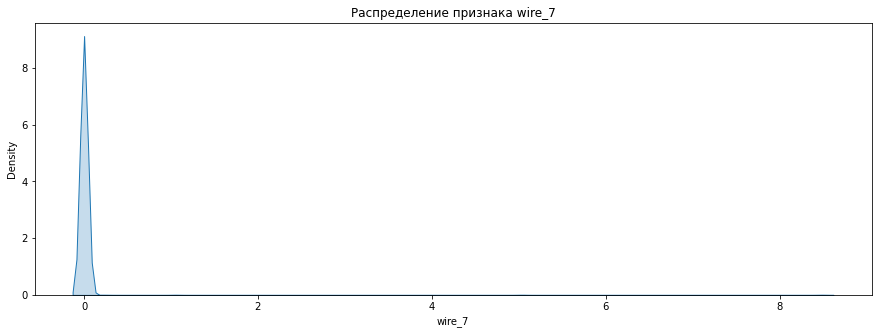

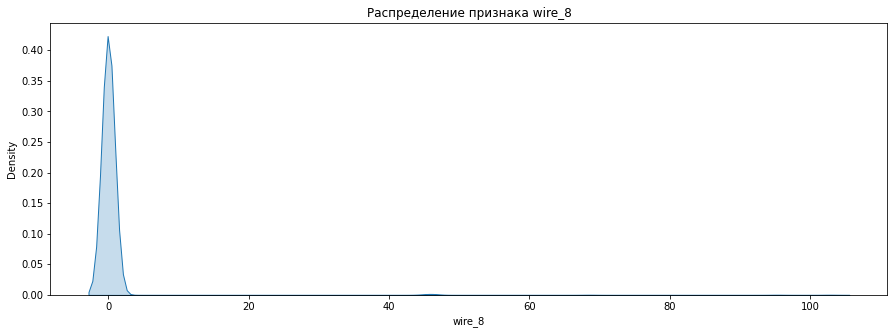

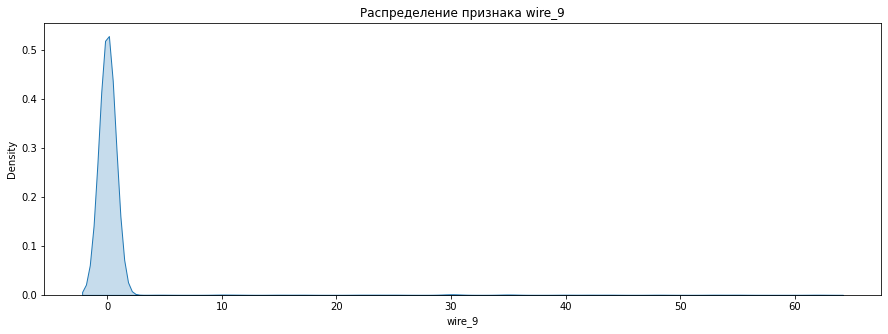

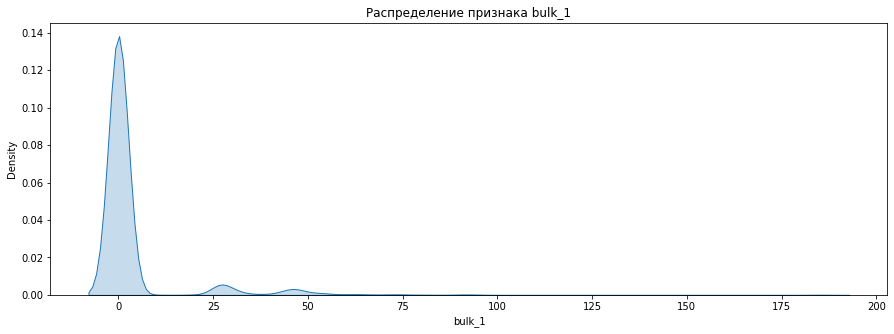

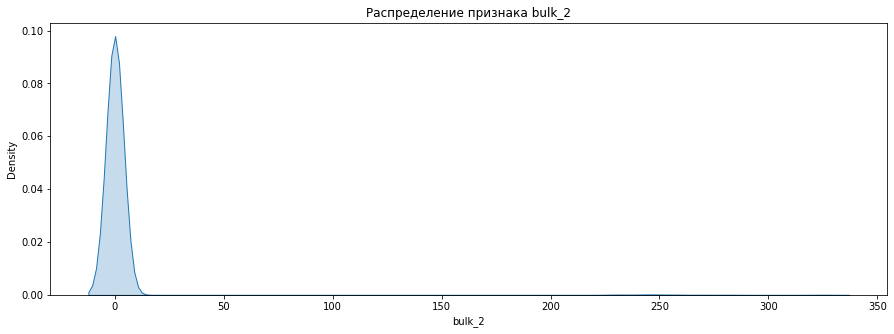

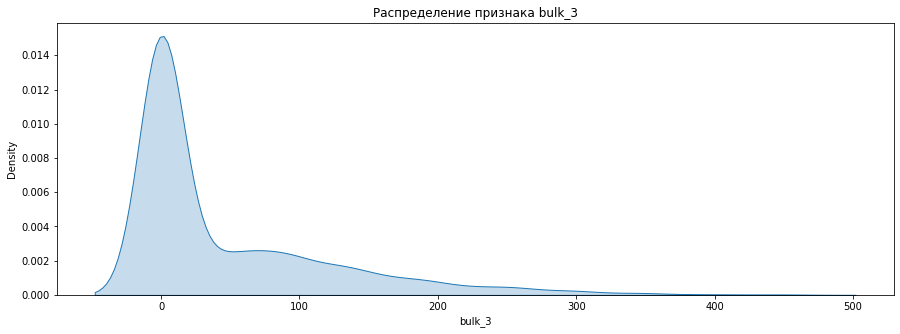

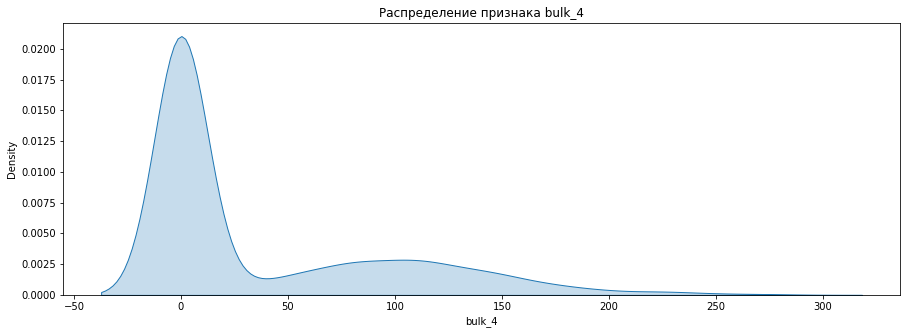

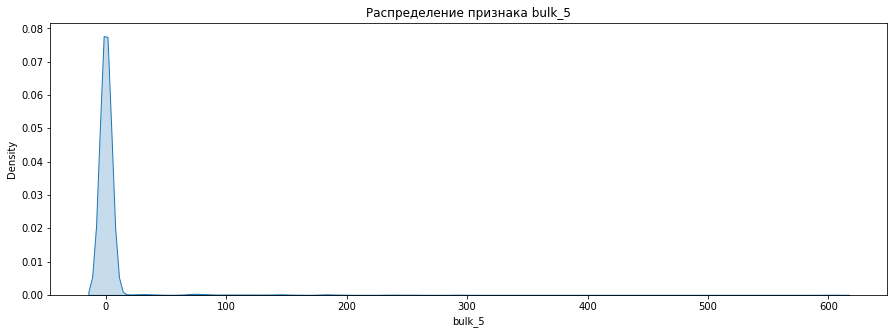

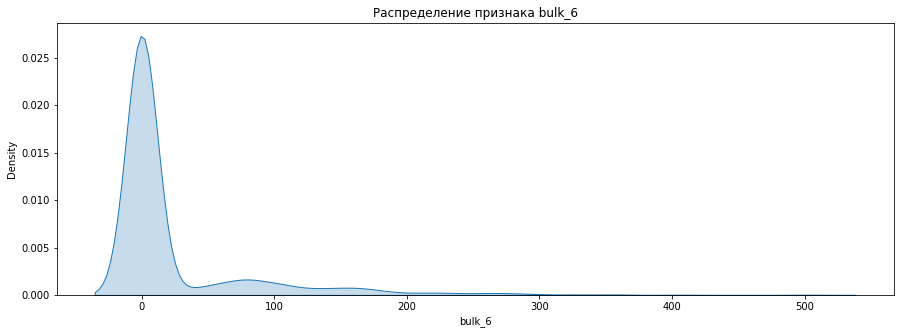

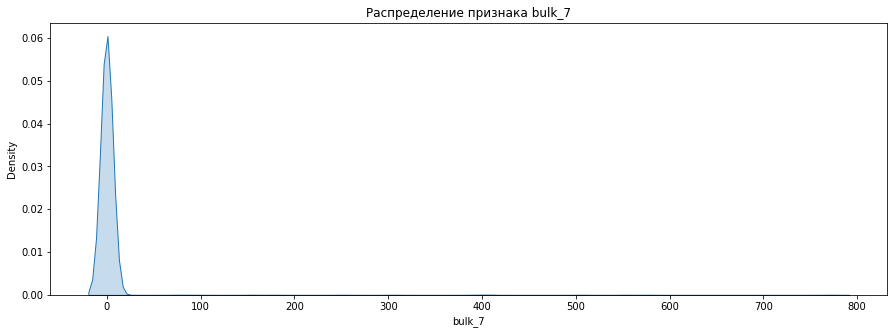

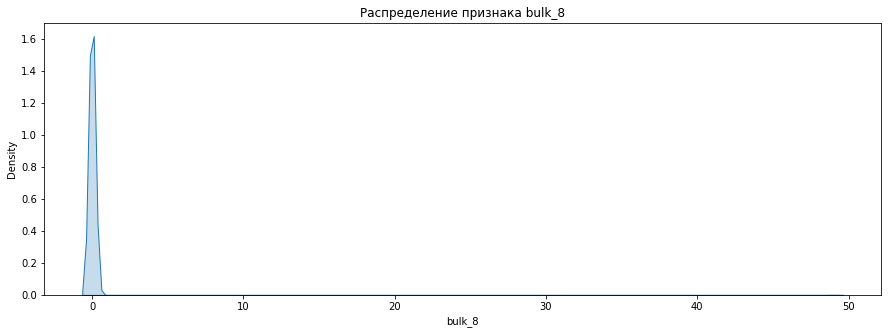

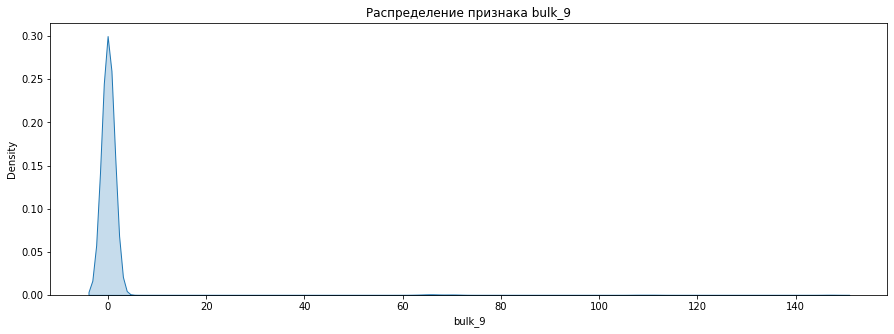

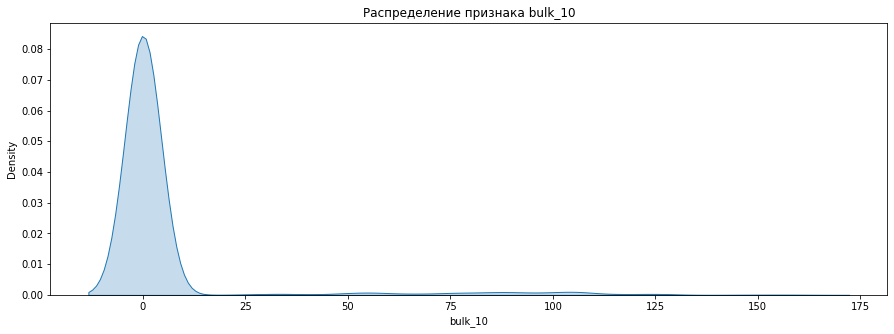

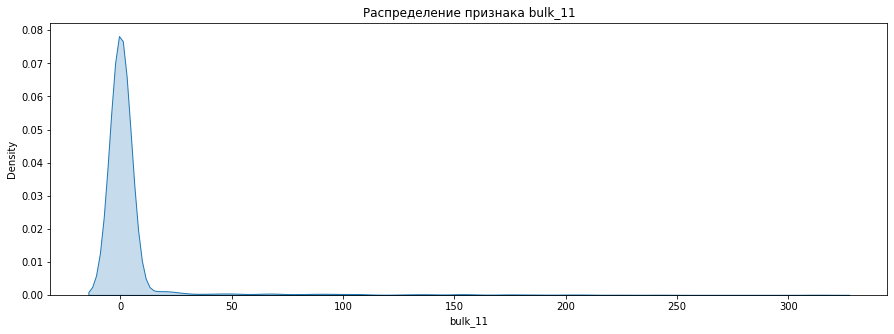

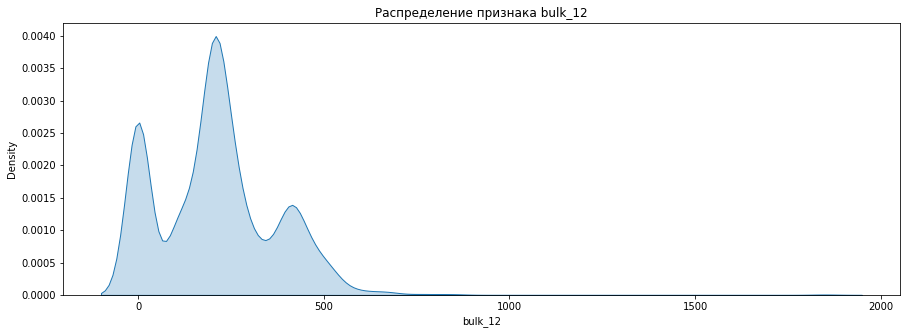

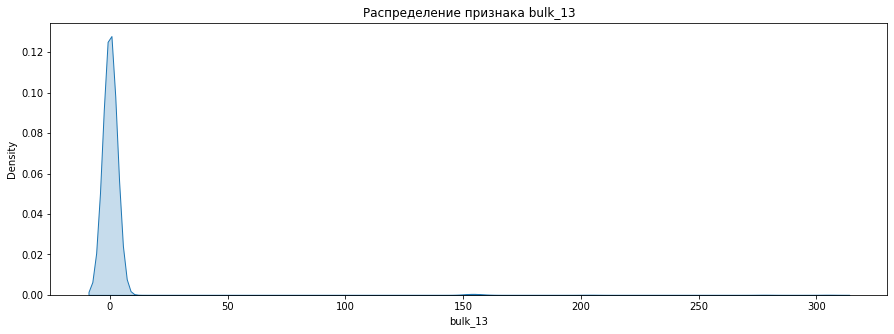

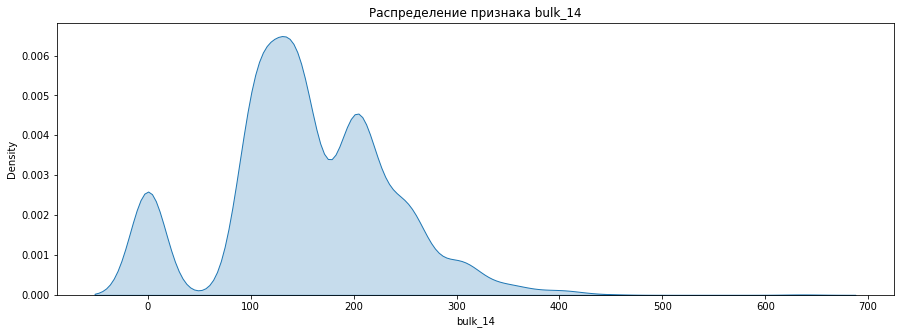

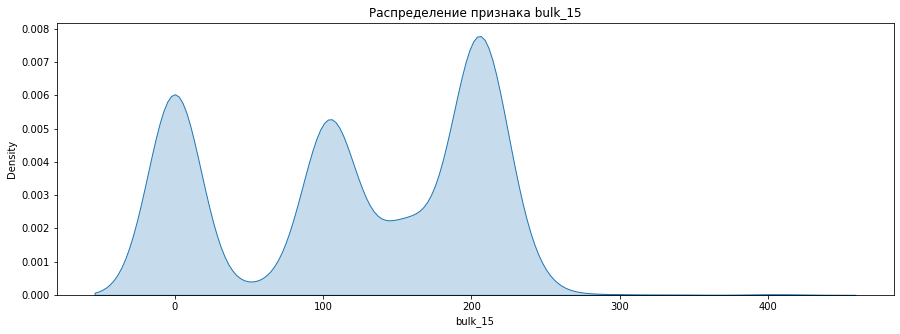

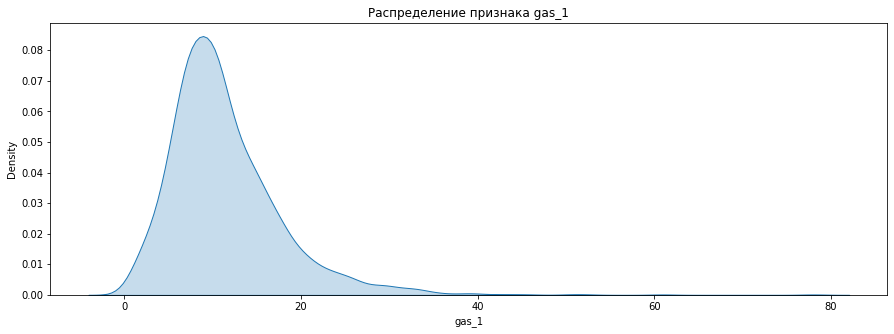

In [48]:
features = data.columns.tolist()

for feature in features:
    plt.figure(figsize=(15, 5))
    fig = sns.kdeplot(data[feature], legend=True, shade=True)
    plt.title(f'Распределение признака {feature}')
    plt.show()


В целом распределения признаков близки к нормальным с небольшой правой ассиметрией. Исключения составлют добавки bulk_12, bulk_14 и bulk_15 и count_iter  - заметны несколько пиков, скорее всего это связано с технологией плавления стали

Внимательнее посмотрим на значимую корреляцию между признаками

In [49]:
data.corr().unstack()[(data.corr().unstack() < 1) & (abs(data.corr().unstack()) > 0.7)]

count_iter  full_power    0.883463
full_power  count_iter    0.883463
wire_4      bulk_7        0.740572
wire_8      bulk_9        0.974969
bulk_7      wire_4        0.740572
bulk_9      wire_8        0.974969
dtype: float64

Высокая корреляция наблюдается между характеристиками электродов. Некоторые сыпучие и проволочные материалы вероятно используют чаще всего вместе и в коррелирующих пропорциях. У признаков wire_8 и bulk_9 самая большая корреляция. Дополнительно посмотрим на признаки сильнее всего коррелирующие с целевым признаком.

In [50]:
corr_target=pd.Series()
for col in data.columns:
    corr_target[col] = data['temp_2'].corr(data[col])
corr_target= corr_target.sort_values(ascending=False)[1:]

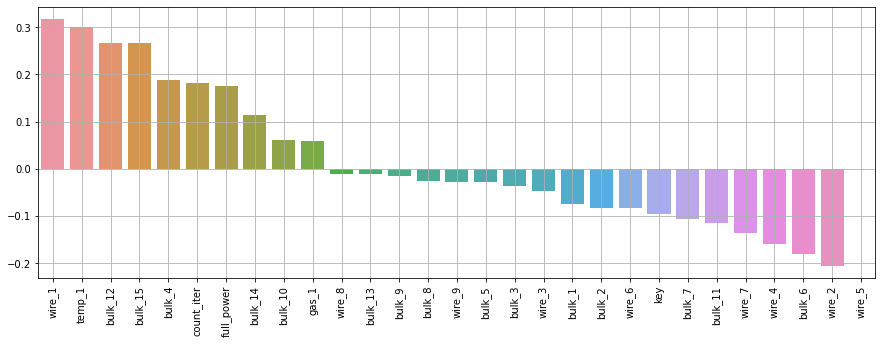

In [51]:
plt.figure(figsize=(15,5))
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.grid()
plt.xticks(rotation=90)
plt.show();

In [52]:
data

,key,temp_1,temp_2,count_iter,full_power,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
0,1,1571.0,1613.0,5,3.716640,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,4,2.586371,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,5,5.014163,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,4,3.399456,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,4,2.815155,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,4,3.863328,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,6,5.067396,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,3,4.360104,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,5,3.907887,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Промежуточный вывод. Мы определили количество итераций нагрева, удалили ненужные данные, определили начальный и конечный замер температуры, объединили данные в одну таблицу.

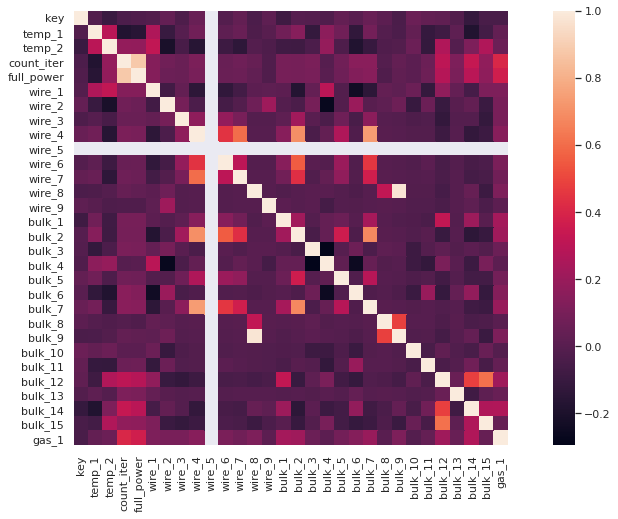

In [53]:
sns.set(rc = {'figure.figsize':(16, 8)})
sns.heatmap(data.corr(), square=True);

Два признака wire_8 и bulk_9 имеют самую большую корреляцию. 

Проанализируем  wire_8 и bulk_9

In [54]:
print('Перечень партий стали имеющие в составе присадку "bulk_9":\n', data[data['bulk_9']!=0].index)
print('Перечень партий стали имеющие в составе присадку "wire_8":\n', data[data['wire_8']!=0].index)
display(data.loc[data['bulk_9']!=0, ['bulk_9', 'wire_8']])

Перечень партий стали имеющие в составе присадку "bulk_9":
 Int64Index([248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 1667, 1849,
            1850],
           dtype='int64')
Перечень партий стали имеющие в составе присадку "wire_8":
 Int64Index([248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 1667, 1849,
            1850],
           dtype='int64')


,bulk_9,wire_8
248,63.0,46.002319
249,68.0,46.094879
250,65.0,46.187439
251,71.0,46.094879
252,66.0,46.279999
253,70.0,46.187439
254,66.0,46.187439
255,70.0,45.354401
256,66.0,45.076721
257,65.0,45.076721


При построении моделей один из признаков надо будет удалить, согласно твоему комментарию, Александр. Я совсем не уверен в этом, ведь все партии стали, содержащие bulk_9, обязательно содержат wire_8, и наоборот. В случае с мощностью понятно, существует даже формула зависимости полной мощности от активной и реактивной. А здесь это технология производства, ок, удалим. Количество итераций вероятно лишнее также.

Удалим ненужные признаки

In [55]:
data.drop(['wire_8', 'count_iter'], axis = 1, inplace=True)

In [56]:
data

,key,temp_1,temp_2,full_power,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
0,1,1571.0,1613.0,3.716640,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,2.586371,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,5.014163,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.399456,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,2.815155,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.863328,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,5.067396,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,4.360104,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,3.907887,118.110717,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Подготовим данные для построения модели

In [72]:
features = data.drop(['key', 'temp_2'], axis=1)
target = data['temp_2']

In [73]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=RANDOM_STATE)

In [74]:
features_train.columns

Index(['temp_1', 'full_power', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_5', 'wire_6', 'wire_7', 'wire_9', 'bulk_1', 'bulk_2', 'bulk_3',
       'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1'],
      dtype='object')

In [75]:
X_train = features_train.columns

In [76]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1746, 26), (583, 26), (1746,), (583,))

Выборки разделены согласно условиям задачи

Масштабируем данные для обучающей и тестовой выборок, чтобы уменьшить переобучение

In [77]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Построение моделей для предсказания 

Модель LinearRegression

In [62]:
model_LR = LinearRegression()
scores = abs(cross_val_score(model_LR, features_train,\
                             target_train, cv=5, scoring='neg_mean_absolute_error'))

print('MAE:', scores.mean())

MAE: 7.26574334672767


Модель CatBoostRegressor

In [64]:
model_CB = CatBoostRegressor(learning_rate=0.04, verbose = 1000, \
                             loss_function = 'MAE', random_state=RANDOM_STATE)
scores = abs(cross_val_score(model_CB, features_train, \
                             target_train, cv=5, scoring='neg_mean_absolute_error'))

print('MAE:', scores.mean())

0:	learn: 8.0947268	total: 50.3ms	remaining: 50.2s
999:	learn: 3.5815098	total: 3.19s	remaining: 0us
0:	learn: 8.1524400	total: 5.28ms	remaining: 5.27s
999:	learn: 3.6684886	total: 2.98s	remaining: 0us
0:	learn: 7.8880162	total: 7.3ms	remaining: 7.3s
999:	learn: 3.5617109	total: 2.81s	remaining: 0us
0:	learn: 8.0544586	total: 4.68ms	remaining: 4.67s
999:	learn: 3.5420174	total: 2.86s	remaining: 0us
0:	learn: 7.9451386	total: 3.19ms	remaining: 3.18s
999:	learn: 3.4565056	total: 2.85s	remaining: 0us
MAE: 6.912615429112608


Модель RandomForest

In [65]:
%%time

rfr = RandomForestRegressor() 

rfr_params = [{'criterion':['mae'],
               'n_estimators':[x for x in range(100, 501, 50)],
               'random_state':[RANDOM_STATE]}]

gscv = GridSearchCV(rfr, rfr_params, scoring='neg_mean_absolute_error', cv=3)
gscv.fit(features_train, target_train)

print('Параметры:', gscv.best_params_)
print()

MAE_rfr = max(gscv.cv_results_['mean_test_score']) * -1
print('MAE для случайного леса  ', MAE_rfr)
print()

Параметры: {'criterion': 'mae', 'n_estimators': 450, 'random_state': 170723}

MAE для случайного леса   7.033377243222603

CPU times: user 11min 6s, sys: 1.12 s, total: 11min 8s
Wall time: 11min 9s


Промежуточный вывод. Лучшую метрику МАЕ = 6.9126 показала модель CatBoostRegressor

### Проверка эффективности лучшей модели на тестовой выборке

In [67]:
model = CatBoostRegressor(verbose = 200, loss_function = 'MAE', random_state=RANDOM_STATE)
model.fit(features_train, target_train)
pred_test = model.predict(features_test)

final_score = mean_absolute_error(target_test, pred_test)
R2 = r2_score(target_test, pred_test)

print('MAE:', final_score)
print('R2:', R2)

0:	learn: 8.0462648	total: 3.54ms	remaining: 3.54s
200:	learn: 5.7853954	total: 640ms	remaining: 2.54s
400:	learn: 5.1366199	total: 1.26s	remaining: 1.88s
600:	learn: 4.7072050	total: 1.97s	remaining: 1.31s
800:	learn: 4.4354013	total: 2.67s	remaining: 663ms
999:	learn: 4.2175233	total: 3.31s	remaining: 0us
MAE: 6.775508625124843
R2: 0.3109264310038212


На тестовой выборке МАЕ = 6.7756, коофициент детерминации R2 = 0.3109 (0 < R2 < 1, положительный) - это означает, что построенная модель адекватна и действительно что-то предсказывает

**Проверка модели на вменяемость**

In [68]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train, target_train)   
    predict = dummy.predict(features_test)   
    MAE_dummy = mean_absolute_error(target_test, predict)   
    print('Для стратегии', strategy, 'MAE  ', MAE_dummy)

Для стратегии mean MAE   7.915954919747958
Для стратегии median MAE   7.900514579759863


Метрика МАЕ на тестовой выборке от DummyRegressor выше, чем CatBoostRegressor. Модель прошла проверку на вменяемость

**Анализ значимости признаков для предсказания**

Learning rate set to 0.044712
0:	learn: 11.1334514	total: 3.34ms	remaining: 3.34s
200:	learn: 7.6982417	total: 632ms	remaining: 2.51s
400:	learn: 6.7672381	total: 1.3s	remaining: 1.94s
600:	learn: 6.0708116	total: 1.97s	remaining: 1.31s
800:	learn: 5.3853166	total: 2.6s	remaining: 647ms
999:	learn: 4.7531670	total: 3.27s	remaining: 0us


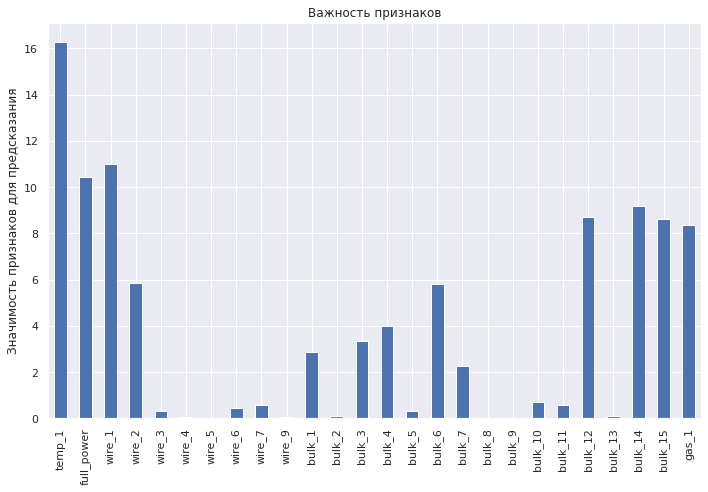

In [84]:
feature_names = X_train 
model = CatBoostRegressor(verbose = 200, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel("Значимость признаков для предсказания")
fig.tight_layout()

На графике видно, что на целевой признак temp_2 в большей степени влияют 3 признака - temp_1, full_power и wire_1, остальные признаки имеют меньшее влияние на конечную температуру. А некоторые признаки не имеют воообще никакого влияния на целевой признак.

### Вывод

В ходе выполнения проекта было необходимо построить модель, которая предскажет температуру стали. В результате EDA были выявлены пропущенные занчения в датасетах, некоторые аномалии в данных, установлено разное количество и значений партий (key) в таблицах. При подготовке выбросы были удалены, пропуски частично удалены или заполнены нулями.Были выведены дополнительные признаки - время между замерами температуры и полная мощность, подаваемую при нагреве. Полученные таблицы были объединены по номеру партии key и по тем номерам партий, которые были во всех датасетах. Также была изучена корреляция признаков, в результате была выявлена сильная корреляция между двумя признаками (легирующими добавками), но не выявлено сильной зависимости признаков с целевым - финальной температурой на этапе. Для предсказаний были выбраны модели - LinearRegression, Polynomial regression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor, XGBRegressor с масштабированием и кросс-валидацией. От  LGBMRegressor и XGBRegressor отказался по причине длительной обработки (более 30 минут на платформе). Лучший результат MAE = 6.9126 на тренировочной выборке показала CatBoostRegressor. При проверке ее эффективности на тестовой выборке метрика МАЕ улучшилась и составила 6.7756. Дополнительно рассчитана метрика R2 = 0.3109.
Проверку на вменяемость модель прошла. Таким образом, для предсказания температуры стали рекомендована модель  CatBoostRegressor, которая ошибается на 6.78 градусов.

### Отчет о проделанной работе

**1. Выполнение плана**

План работы составленный в  начале исследования не подвергался изменениям или дополнениям. Все пункты выполнены в полном объеме.

**2. Трудности в проекте и методы их решения**

Возникали затруднения на этапе знакомства с данными ввиду большого количества параметров, часть из которых не была достаточна информативна. Этап получился более продолжительный, чем ожидалось. На этапе EDA были обнаружены пропуски данных, связанные с неподачей легирующих добавок, что было решено заменой на 0. Была выявлена также отрицательная реактивная мощность, температура плавления ниже 1500, что было исключено из анализа, как аномалия. Кроме того, во всех датафреймах количество и перечень номеров партий (признак-столбец key) было разное, поэтому при объединении таблиц для анализа былии взяты только те партии, данные по которым были во всех датасетах.

**3. Ключевые шаги в решении задачи**

В проекте выделю несколько ключевых шагов:

1. Знакомство с данными производственного процесса, изучение технологического процесса обработки стали. 
2. EDA и последующая предобработка и подготовка данных, обеспечивающих качественный анализ и лучшую работу моделей
3. Обучение и выбор лучшей модели с использованием метрики MAE 
4. Оценка эффективности модели, проверка ее на вменяемость и анализ важности признаков

**4. Признаки использованные для обучения модели и их предобработка**

Для итоговой выборки данных использованы следующие признаки:

1. Начальная температура из датасета data_temp_new.csv, удалены пропуски и аномалии
2. Данные по времени нагревов (начало и конец) из датасета data_arc_new.csv, удалена отрицательная аномалия, рассчитана полная мощность, данные активной, реактивной мощности исключены для использования, типы данных скорректированы.
3. Данные о финальной температуре нагрева из датасета data_temp_new.csv, удалены пропуски и значения ниже 1500 градусов, согласно условию задачи, типы данных приведены в порядок.
4. Данные по количеству и виду добавленных присадок из датасетов data_bulk_new.csv и data_wire_new.csv, пропущенные значения заменены нулями.
5. Данные по объёму прокаченного инертного газа из датасета data_gas_new.csv, обработка данных не проводилась, аномалий не обнаружено.
6. Исследована величина корреляции между признаками, удален признак wire_8.

**5. Итоговая модель, ее гиперпараметры и качество**

Итоговой моделью, с наименьшей МАЕ среди обученных, стал **CatBoostRegressor** на основе стохастического градиентного бустинга с функцией потерь mean_absolute_error. Гиперпараметр модели learning rate (скорость обучения) = 0.04 и генератор псевдослучайных чисел random_state = 170723 (по условию задачи). Метрика МАЕ итоговой модели на кросс-валидации тренировочной выборки составила 6.9126, а на тестовой выборке МАЕ составила 6.7755. Дополнительно рассчитанный коофициент детерминации R2 = 0.3109 подтверждает положительное качество итоговой модели, а ее вменяемость подтверждает метрика МАЕ DummyRegressor на тестовой выборке.